# Segmentasi Tumor Otak

In [1]:
import os
import cv2
import glob
import time
import joblib
import pathlib
import numpy as np
import nibabel as nib
import tensorflow as tf
import tensorflow_graphics as tfg
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tqdm import tqdm
from keras.models import Model
from keras.metrics import MeanIoU
from matplotlib import pyplot as plt
from tensorflow.keras.utils import normalize
from IPython.display import display, Markdown
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow_graphics.nn.loss.hausdorff_distance import evaluate as hausdorff_distance_eval
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

## Pengaturan Hyperparameter dan Konfigurasi Model

In [2]:
# Menginisialisasi hyperparameter
INIT_LR = 1e-3
EPOCHS = 250
BS = 128
SIZE_X = 112
SIZE_Y = 112
n_classes = 4
IMG_CHANNELS = 1

NETWORK = "UNet_Tesis"

dataset = "C:/Users/Lab129/Downloads/Indi/Dataset Seg 128"
model_path = f"{NETWORK}_{SIZE_X}_{EPOCHS}_{BS}.model"
encoder_path = model_path + "_encoder.joblib"

## Pre-processing Data

In [3]:
data_dir=pathlib.Path(dataset)

images_dir = [str(dir) for dir in data_dir.glob('*/Images/*.jpg')]
masks_dir = [str(dir) for dir in data_dir.glob('*/Masks/*.png')]
display(
    Markdown(f"**Training images**: {len(images_dir)}"),
    Markdown(f"**Mask images**: {len(masks_dir)}")
)

**Training images**: 47232

**Mask images**: 47232

In [4]:
X_dirs, X_dirs_test, y_dirs, y_dirs_test = train_test_split(images_dir, masks_dir, test_size=0.20, random_state=42)

In [5]:
def image_generator(image_paths: list[str], interpolation=None):
    for index, image_path in enumerate(image_paths):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if interpolation is not None:
            image = cv2.resize(image, (SIZE_X, SIZE_Y), interpolation=interpolation)
        else:
            image = cv2.resize(image, (SIZE_X, SIZE_Y))
        yield image

In [6]:
encoder = LabelEncoder()
# Periksa encoder
if os.path.exists(encoder_path):
    display(Markdown("**Loading encoder from file**"))
    encoder: LabelEncoder = joblib.load(encoder_path)
else:
    display(Markdown("**Images on encoder**"))
    batch_size=1
    generator = image_generator(y_dirs, interpolation=cv2.INTER_NEAREST)
    # Memuat progress bar saat memuat gambar
    uniques = set()
    for matrice in tqdm(generator, total=len(y_dirs), desc="Fitting images on encoder..."):
        uniques.update(np.unique(matrice.flatten()))
    encoder.fit(list(uniques))
    joblib.dump(encoder, encoder_path)
encoder.classes_

**Images on encoder**

Fitting images on encoder...: 100%|███████████████████████████████████████████████████████████████████████| 37785/37785 [00:28<00:00, 1343.33it/s]


array([  0,  64, 128, 255], dtype=uint8)

In [7]:
def data_generator(xdirs, ydirs):
    X_gen = image_generator(xdirs)
    y_gen = image_generator(ydirs, interpolation=cv2.INTER_NEAREST)
    while True:
        try:
            X, y = next(X_gen), next(y_gen)

            h, w = y.shape
            
            X = np.expand_dims(X, axis=2)

            X: np.ndarray = normalize(X, axis=1)

            y_res_encode: np.ndarray = encoder.transform(y.reshape(-1,1).ravel())
            y_encoded = y_res_encode.reshape(h, w)

            y_expanded = np.expand_dims(y_encoded, axis=2)

            y_cat: np.ndarray = to_categorical(y_expanded.ravel(), num_classes=n_classes)
            y_cat = y_cat.reshape((h, w, n_classes))
            yield X, y_cat
        except StopIteration:
            return

In [8]:
val_total_items = len(X_dirs_test)
val_num_batches = val_total_items // BS
val_dataset = tf.data.Dataset.from_generator(lambda: data_generator(X_dirs_test, y_dirs_test),
    output_types=(tf.float32, tf.float32),  # Assuming X and y are both float32
    output_shapes=((None, None, 1), (None, None, n_classes))  # Assuming the shapes of X and y
)
val_dataset = val_dataset.batch(BS)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

train_total_items = len(X_dirs)
train_num_batches = train_total_items // BS
train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(X_dirs, y_dirs),
    output_types=(tf.float32, tf.float32),  # Assuming X and y are both float32
    output_shapes=((None, None, 1), (None, None, n_classes))  # Assuming the shapes of X and y
)
train_dataset = train_dataset.batch(BS)
train_dataset = train_dataset.repeat(EPOCHS)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

## Pengembangan Model

In [9]:
starttime = time.time()

def multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=IMG_CHANNELS):
# Mengembangkan model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [10]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def hd95_metric(y_true, y_pred):
    value = tfg.nn.loss.hausdorff_distance.evaluate(y_true, y_pred)
    percentile = tfp.stats.percentile(value, 95.0, interpolation='lower')
    return percentile

In [11]:
model = multi_unet_model()

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), 
              metrics = [
                  'accuracy',
                  tf.keras.metrics.MeanIoU(num_classes=n_classes),
                  dice_coef, 
                  precision,
                  sensitivity,
                  specificity,
                  hd95_metric,
              ])

[INFO] compiling model...


## Proses Pelatihan Model

In [12]:
print("[INFO] training...")
history = model.fit(train_dataset,
                    batch_size=BS, 
                    verbose=1, 
                    steps_per_epoch=train_num_batches,
                    epochs=EPOCHS, 
                    validation_data=val_dataset,
                    validation_steps=val_num_batches,
                    validation_batch_size=BS,
                    shuffle=False)

endtime = time.time()

# Tampilkan running time
print("Running time: {} s".format(endtime - starttime))

[INFO] training...
Epoch 1/250
295/295 [==============================] - 252s 826ms/step - loss: 0.0769 - accuracy: 0.9806 - mean_io_u: 0.7049 - dice_coef: 0.3194 - precision: 0.9830 - sensitivity: 0.9707 - specificity: 0.9965 - hd95_metric: 1.0078 - val_loss: 0.0425 - val_accuracy: 0.9875 - val_mean_io_u: 0.6479 - val_dice_coef: 0.3652 - val_precision: 0.9967 - val_sensitivity: 0.9803 - val_specificity: 0.9989 - val_hd95_metric: 0.8134
Epoch 2/250
295/295 [==============================] - 243s 824ms/step - loss: 0.0318 - accuracy: 0.9889 - mean_io_u: 0.7578 - dice_coef: 0.4061 - precision: 0.9952 - sensitivity: 0.9848 - specificity: 0.9984 - hd95_metric: 0.8339 - val_loss: 0.0303 - val_accuracy: 0.9890 - val_mean_io_u: 0.7466 - val_dice_coef: 0.4133 - val_precision: 0.9979 - val_sensitivity: 0.9827 - val_specificity: 0.9993 - val_hd95_metric: 0.7706
Epoch 3/250
295/295 [==============================] - 243s 823ms/step - loss: 0.0270 - accuracy: 0.9896 - mean_io_u: 0.8183 - dice_coe

## Penyimpanan Model dan Visualisasi

[INFO] saving brain tumor segmentation model...
UNet_Tesis_Baru_112_250_128.model


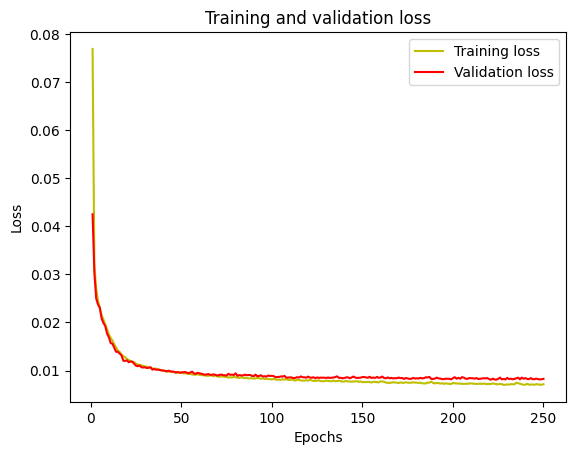

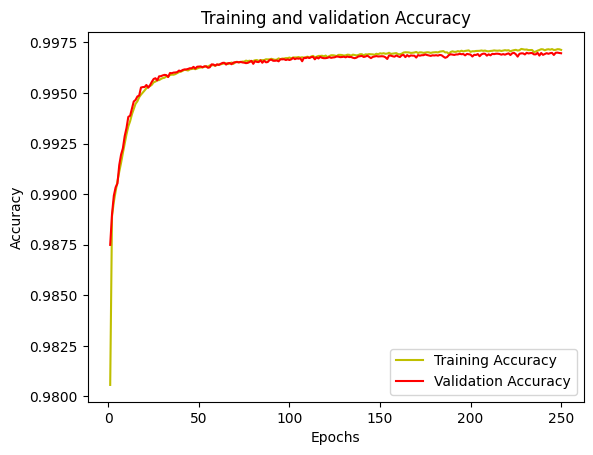

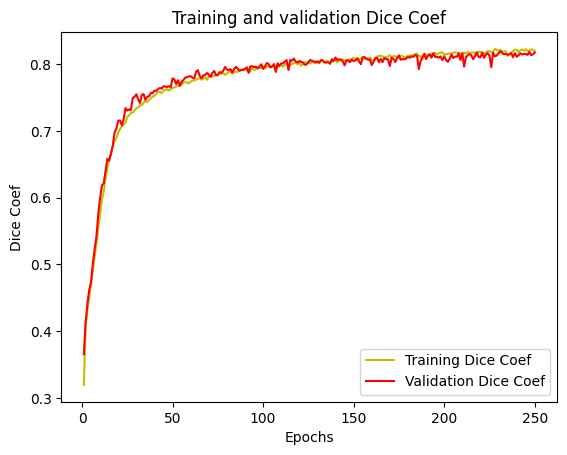

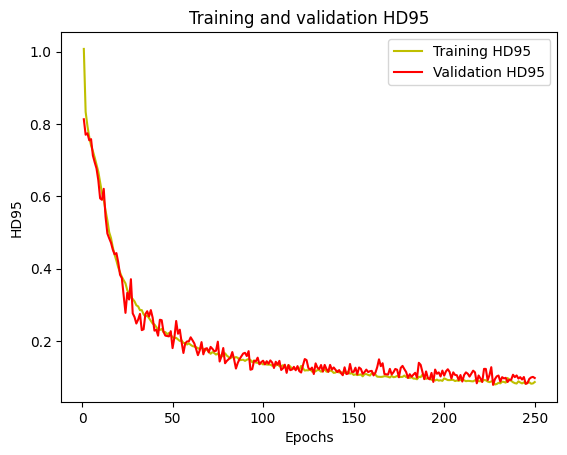

In [13]:
print("[INFO] saving brain tumor segmentation model...")
model.save(model_path, save_format="h5")  # Save dalam format .h5
print(model_path)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']
plt.plot(epochs, dice_coef, 'y', label='Training Dice Coef')
plt.plot(epochs, val_dice_coef, 'r', label='Validation Dice Coef')
plt.title('Training and validation Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()
plt.show()

hd95_metric = history.history['hd95_metric']
val_hd95_metric = history.history['val_hd95_metric']
plt.plot(epochs, hd95_metric, 'y', label='Training HD95')
plt.plot(epochs, val_hd95_metric, 'r', label='Validation HD95')
plt.title('Training and validation HD95')
plt.xlabel('Epochs')
plt.ylabel('HD95')
plt.legend()
plt.show()

## Uji Coba dan Evaluasi Model

In [14]:
# Evaluasi model
print("[INFO] evaluating network...")
_, acc, mean_io_u, dice_coef, precision, sensitivity, specificity, hd95_metric = model.evaluate(val_dataset, 
                    batch_size=BS, steps=val_num_batches)

# Tampilkan hasil evaluasi model
print("Accuracy:", round(acc * 100.0), "%")
print("Mean IoU:", round(mean_io_u * 100.0), "%")
print("Dice Coefficient:", round(dice_coef * 100.0), "%")
print("Precision:", round(precision * 100.0), "%")
print("Sensitivity:", round(sensitivity * 100.0), "%")
print("Specificity:", round(specificity * 100.0), "%")
print("HD95:", (hd95_metric), "mm")

[INFO] evaluating network...
73/73 [==============================] - 43s 583ms/step - loss: 0.0083 - accuracy: 0.9970 - mean_io_u: 0.9350 - dice_coef: 0.8177 - precision: 0.9972 - sensitivity: 0.9968 - specificity: 0.9991 - hd95_metric: 0.0980
Accuracy: 100 %
Mean IoU: 94 %
Dice Coefficient: 82 %
Precision: 100 %
Sensitivity: 100 %
Specificity: 100 %
HD95: 0.09801630675792694 mm
